In [1]:
import os
import csv
import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.models import Model
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Cropping2D
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
import random
from sklearn.utils import shuffle
from keras.utils import plot_model
#from keras.utils.visualize_util import plot
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import BatchNormalization


Using TensorFlow backend.


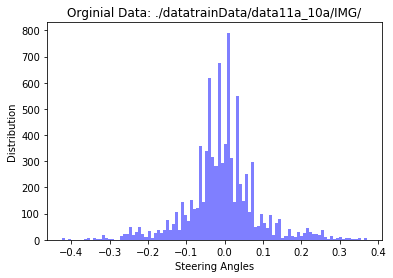

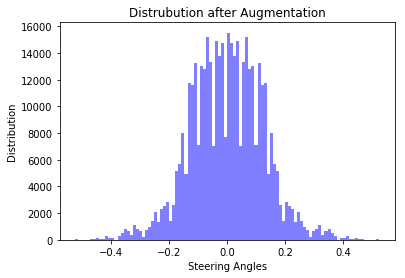

Done


In [2]:





correction = 0.1 #  0.25 parameter to tune
del_rate = 0.5 # 0.8
cut_value = 99   # 0.02  0.5
batch_size = 16
current_path1 = './datatrainData/data11a_10a/IMG/'
samples = []
with open("./datatrainData/data11a_10a/driving_log.csv") as csvfile:
    reader  = csv.reader(csvfile)
    for sample in reader:
        samples.append(sample)
        
del(samples[0]) # delete the first row of column names
train_samples, validation_samples = train_test_split(samples,test_size = 0.2)

#Histogram before balanced steering angle
angles_b4balanced = []
for train_sample in train_samples:
    source_path = train_sample[0]
    filename = source_path.split('/')[-1]
    #print(filename)
    current_path = current_path1 + filename
    image = cv2.imread(current_path)
    angle = float(train_sample[3])
    angles_b4balanced.append(angle)

#Histogram before balanced steering angle
num_bins = 100
n, bins, patches = plt.hist(angles_b4balanced, num_bins,facecolor='blue', alpha=0.5)
plt.xlabel('Steering Angles')
plt.ylabel('Distribution')
plt.title('Orginial Data: ' + current_path1)
plt.show()



def RandomBrightness(image):
    # convert to HSV 
    RandomImage = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    # randomly generate brightness value
    # define range dark to bright
    random_bright = np.random.uniform(0.25,1.0)
    # Apply the brightness to V channel
    RandomImage[:,:,2] = RandomImage[:,:,2]*random_bright
    # back to RGB
    RandomImage = cv2.cvtColor(RandomImage,cv2.COLOR_HSV2RGB)
    return RandomImage



def generator(samples, batch_size=16):
    num_samples = len(samples)
    
    
    
    while 1: # Loop forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            steerings = []
            count =0
            for batch_sample in batch_samples:
                for i in range(3):
                    source_path = batch_sample[i]
                    count +=1
                    # print(count,end="\r",)
                    print(count, end ="\r",)
                    filename = source_path.split('/')[-1]
                    current_path = './datatrainData/data11a_10a/IMG/' + filename
                    image = cv2.imread(current_path)
                    #print(filename)
                    #print(current_path)
                    #plt.imshow(image)
                    #image = image.astype('uint8')
                    

                    if i == 0:
                        steering = float(batch_sample[3])
                    elif i == 1:
                        steering = float(batch_sample[3]) + correction # Left
                    else:
                        steering = float(batch_sample[3]) - correction # Right
                    
                    if abs(steering) > cut_value or np.random.random() > del_rate:
                        image = RandomBrightness(image) # random brightness
                        images.append(image)
                        steerings.append(steering)
                        image_flipped = np.fliplr(image)
                        steering_flipped = -steering
                        images.append(image_flipped)
                        steerings.append(steering_flipped)


            #Build train
            X_train = np.array(images)
            y_train = np.array(steerings)
            yield shuffle(X_train, y_train)



# compile and train the model using the generator function
#import time
#t0 = time.time()


train_generator = generator(train_samples, batch_size=16)
validation_generator = generator(validation_samples, batch_size=16)

#t1=time.time()
#print("Time to load in secs: {} s".format(round(t1-t0)))


#Histogram after balanced steering angle
angles = np.array([], dtype=np.float32)

for i in range(len(train_samples)):
    X_batch, y_batch = next(train_generator)
    angles = np.concatenate((angles, y_batch))

num_bins = 100
n, bins, patches = plt.hist(angles, num_bins,facecolor='blue', alpha=0.5)
plt.xlabel('Steering Angles')
plt.ylabel('Distribution')
plt.title('Distrubution after Augmentation')
plt.show()

#print('X_batch 0  ',X_batch[0]  )
#print('y_batch 0  ',y_batch[0]  )

print("Done")

In [3]:
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D
from keras.layers import ELU
from keras.callbacks import  ModelCheckpoint

def resize(img):
    import tensorflow
    return tensorflow.image.resize_images(img,(60,120))

# network
model = Sequential()

# Crop 70 pixels from the top of the image and 25 from the bottom
model.add(Cropping2D(cropping=((75, 25), (0, 0)),
                     input_shape=(160, 320, 3),
                     data_format="channels_last"))

# Resize the data
model.add(Lambda(resize))

# Normalize the data
model.add(Lambda(lambda x: (x/127.5) - 0.5))

model.add(Conv2D(3, (1, 1), padding='same'))
model.add(ELU())

model.add(BatchNormalization())
model.add(Conv2D(16, (5, 5), strides=(2, 2), padding="same"))
model.add(ELU())

model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
model.add(ELU())

model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
model.add(ELU())

model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
model.add(ELU())

model.add(Flatten())
model.add(Dropout(.5))
model.add(ELU())

model.add(Dense(512))
#model.add(Dropout(.2))
model.add(ELU())

model.add(Dense(100))
model.add(Dropout(.5))
model.add(ELU())

model.add(Dense(10))
#model.add(Dropout(.5))
model.add(ELU())

model.add(Dense(1))

adam = Adam(lr=1e-5)
model.compile(loss = 'mse',optimizer = 'adam',metrics =['accuracy'])
#
model.summary()
print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 60, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 60, 120, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 60, 120, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 120, 3)        12        
_________________________________________________________________
elu_1 (ELU)                  (None, 60, 120, 3)        0         
_________________________________________________________________
batch_normalization_1

In [9]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
 #
checkpointer = ModelCheckpoint('model_best.h5',monitor='val_loss',verbose=1, save_best_only=True)
#history_object= model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, batch_size=32, epochs = 50,callbacks=[early_stopping])
history_object=model.fit_generator(train_generator,samples_per_epoch = 2*(len(train_samples)),validation_data = validation_generator,nb_val_samples = len(validation_samples),nb_epoch = 5,verbose=2,callbacks=[early_stopping])

model.save('New_model_v4a_M11a_10a_r2_2.h5')   

C:\Users\qzwk52\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
C:\Users\qzwk52\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=2, callbacks=[<keras.ca..., steps_per_epoch=17354, epochs=5, validation_steps=2170)`
  


Epoch 1/5
 - 3260s - loss: 0.0031 - acc: 0.0190 - val_loss: 0.0573 - val_acc: 0.0183
Epoch 2/5
11 - 3258s - loss: 0.0029 - acc: 0.0188 - val_loss: 0.0404 - val_acc: 0.0180
Epoch 3/5
 - 3266s - loss: 0.0037 - acc: 0.0189 - val_loss: 0.0290 - val_acc: 0.0177
Epoch 4/5
12 - 3327s - loss: 0.0026 - acc: 0.0191 - val_loss: 0.0390 - val_acc: 0.0172
Epoch 5/5
 - 3282s - loss: 0.0052 - acc: 0.0190 - val_loss: 0.0289 - val_acc: 0.0180


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


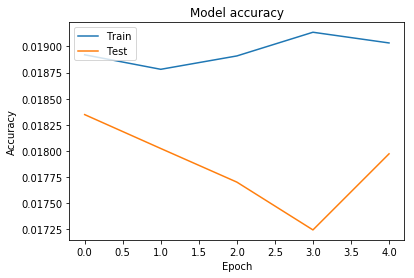

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 60, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 60, 120, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 60, 120, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 120, 3)        12        
_________________________________________________________________
elu_1 (ELU)                  (None, 60, 120, 3)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 120, 3)        12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 60, 16)        1216      
__________

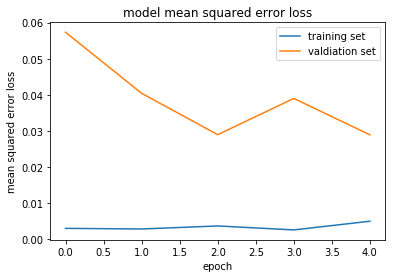

In [11]:

# plot/print some stuff
print(history_object.history.keys())

# Plot training & validation accuracy values
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'valdiation set'],loc='upper right')
plt.show

#Print model
print(model.summary())



#visualize the model
modelobj = load_model('New_model_v4a_M11a_10a_r2_2.h5')
plot_model(modelobj, to_file='New_model_v4a_M11a_10a_r2_2.png')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 60, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 60, 120, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 60, 120, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 120, 3)        12        
_________________________________________________________________
elu_1 (ELU)                  (None, 60, 120, 3)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 120, 3)        12        
_________________________________________________________________
conv2d_2 (Conv2D)         

OSError: Unable to open file (unable to open file: name = 'New_model_v4a_M11a_10a_r1_2.h5.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

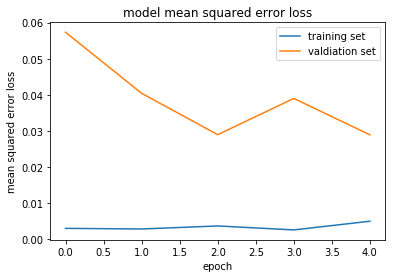

In [12]:
# plot/print some stuff
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'valdiation set'],loc='upper right')
plt.show

print(model.summary())

modelobj = load_model('New_model_v4a_M11a_10a_r1_2.h5.h5')
plot_model(modelobj, to_file='New_model_v4a_M11a_10a_r1_2.h5.png', show_shapes=True, show_layer_names=True)

In [ ]:
# orginial model
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D
from keras.callbacks import  ModelCheckpoint

model = Sequential()

# test 
#model.add(Flatten(input_shape=(160,320,3)))
#model.add(Dense(1))

# real model
# Normalize image
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(3,160,320)))
model.add(Conv2D(24,(5,5), subsample=(2,2)))
# Dropout
#model.add(Dropout(0.5))
# Activation Layer
model.add(Activation('elu'))
# Convolution Layer 2
model.add(Conv2D(36,(5,5), strides=(2,2)))
#model.add(Dropout(0.5))
model.add(Activation('elu'))
# Convolution Layer 3         
model.add(Conv2D(48,(5,5), strides=(2,2)))
#model.add(Dropout(0.5))
model.add(Activation('elu'))
# Convolution Layer 4         
model.add(Conv2D(64,(3,3), strides=(1,1)))
#model.add(Dropout(0.5))
model.add(Activation('elu'))
# Convolution Layer 5          
model.add(Conv2D(24,(3,3), strides=(1,1)))
#model.add(Dropout(0.5))
model.add(Activation('elu'))
#
#model.add(Dropout(0.4))
# Flatten to single 1-D array
model.add(Flatten())
#
model.add(Dropout(0.4))
# Fully connected Layer 1          
model.add(Dense(100))
# Fully connected Layer 2          
model.add(Dense(50))
# Fully connected Layer 3          
model.add(Dense(10))
 # fully connected Layer 4         
model.add(Dense(1))

adam = Adam(lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss = 'mse',optimizer = 'adam',metrics =['accuracy']) #
checkpointer = ModelCheckpoint('org_model_v4a_M10a_r1_2.h5',monitor='val_loss',verbose=1, save_best_only=True)
history_object= model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, batch_size=32, epochs = 50,callbacks=[early_stopping])

model.save('org_model_v4a_M10a_r1_2.h5')
    
model.summary()          
print(model.summary())

In [ ]:
# plot/print some stuff
print(history_object.history.keys())

# Plot training & validation accuracy values
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'valdiation set'],loc='upper right')
plt.show

#Print model
print(model.summary())



#visualize the model
modelobj = load_model('fit_model_v4a_M10a_r1_2.h5')
plot_model(modelobj, to_file='fit_model_v4a_M10a_r1_2.png')

In [ ]:
# plot/print some stuff
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'valdiation set'],loc='upper right')
plt.show

print(model.summary())

modelobj = load_model('org_model_v4a_M10a_r1_2.h5')
plot_model(modelobj, to_file='org_model_v4a_M10a_r1_2.png', show_shapes=True, show_layer_names=True)

In [7]:
#NVIDIA Model 2 model fit
model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5,input_shape = (160,320,3))) # image normalization
model.add(Cropping2D(cropping = ((50,20), (0,0)),input_shape = (160,320,3)))
# start adding other model layers here.

#Convolution:
model.add(Conv2D(24, (5, 5), activation = "relu"))
#MaxPooling:
model.add(MaxPooling2D(pool_size = (2, 2)))
#Convolution:
model.add(Conv2D(36, (5, 5), activation = "relu"))
#MaxPooling:
model.add(MaxPooling2D(pool_size = (2, 2)))
#Convolution:
model.add(Conv2D(48, (3, 3), activation = "relu"))
#MaxPooling:
model.add(MaxPooling2D(pool_size = (2, 2)))
#Convolution:
model.add(Conv2D(64, (3, 3), activation = "relu"))
#MaxPooling:
model.add(MaxPooling2D(pool_size = (2, 2)))
#Flatten:
model.add(Flatten())
model.add(Dropout(0.5))
#Fully Connected:
model.add(Dense(1164))
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


#Training
adam = Adam(lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss = 'mse', optimizer = 'adam',metrics =['accuracy'])
history_object=model.fit_generator(train_generator,samples_per_epoch = (len(train_samples)),validation_data = validation_generator,nb_val_samples = len(validation_samples),nb_epoch = 5,verbose=2,callbacks=[early_stopping])
#Save the model
model.save('fit_model_v4a_M10a_r1_2.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


C:\Users\qzwk52\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\qzwk52\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., verbose=2, callbacks=[<keras.ca..., steps_per_epoch=5024, epochs=5, validation_steps=1256)`


Epoch 1/5
 - 1944s - loss: 0.0019 - acc: 0.0510 - val_loss: 0.0011 - val_acc: 0.0603
Epoch 2/535
 - 1895s - loss: 0.0012 - acc: 0.0511 - val_loss: 9.2582e-04 - val_acc: 0.0603
Epoch 3/5
 - 1891s - loss: 9.0859e-04 - acc: 0.0511 - val_loss: 0.0011 - val_acc: 0.0605
Epoch 4/5
 - 1914s - loss: 7.5808e-04 - acc: 0.0510 - val_loss: 8.1233e-04 - val_acc: 0.0605
Epoch 5/5
 - 1939s - loss: 6.3696e-04 - acc: 0.0511 - val_loss: 7.3145e-04 - val_acc: 0.0606


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


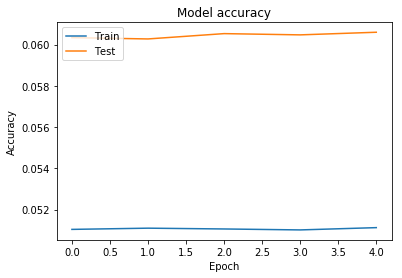

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 316, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 154, 36)       21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 77, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 75, 48)        15600     
__________

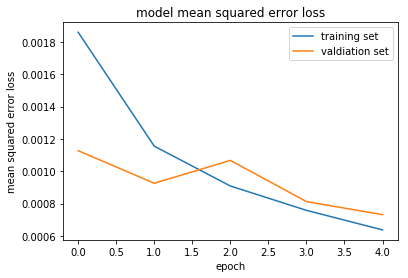

In [8]:


# plot/print some stuff
print(history_object.history.keys())

# Plot training & validation accuracy values
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'valdiation set'],loc='upper right')
plt.show

#Print model
print(model.summary())



#visualize the model
modelobj = load_model('fit_model_v4a_M10a_r1_2.h5')
plot_model(modelobj, to_file='fit_model_v4a_M10a_r1_2.png')


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 316, 24)       1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 154, 36)       21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 77, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)         

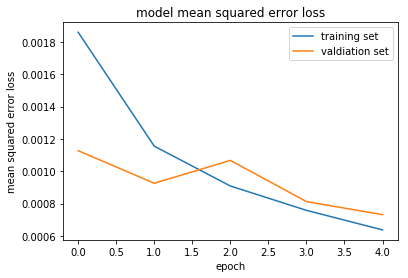

In [9]:
# plot/print some stuff
print(history_object.history.keys())

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'valdiation set'],loc='upper right')
plt.show

print(model.summary())

modelobj = load_model('fit_model_v4a_M10a_r1_2.h5')
plot_model(modelobj, to_file='fit_model_v4a_M10a_r1_2.png', show_shapes=True, show_layer_names=True)